In [25]:
from PIL import Image
import glob
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

In [26]:
output_path = "./output/"
model_type = 'DAN' #@param ['DAN','Transformer','Transformer_Multilingual']

the following codesnippet is partly from https://pythonprogramming.altervista.org/png-to-gif/

In [27]:
def gif_output():
    frames = []
    imgs = glob.glob("./output/clusterpngs/*.png")
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save('./output/animated_plot.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=500, loop=0)

In [28]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

n_clusters: 2 silhouette_avg: 0.4028136
n_clusters: 102 silhouette_avg: 0.33040905
n_clusters: 202 silhouette_avg: 0.34141842
n_clusters: 302 silhouette_avg: 0.3478986
n_clusters: 402 silhouette_avg: 0.36211285
n_clusters: 502 silhouette_avg: 0.3795514
n_clusters: 602 silhouette_avg: 0.40484145
n_clusters: 702 silhouette_avg: 0.42373362
n_clusters: 802 silhouette_avg: 0.44458672
n_clusters: 902 silhouette_avg: 0.46942234


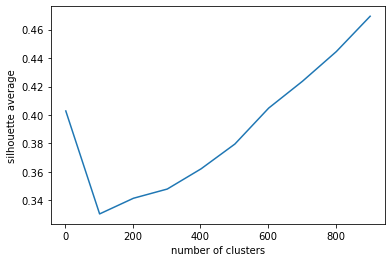

In [29]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

In [30]:
def clustering(clusters):
    number_of_clusters =  clusters
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    clustering_model = KMedoids(n_clusters=number_of_clusters,
                                metric='cosine', 
                                init=init_param, 
                                max_iter=150, 
                                random_state=None).fit(embeddings_umap)
    clustering_model
    labels = clustering_model.labels_
    data["label_kmedoids"] = labels
    # print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

    clustering_model.inertia_

    medoids_indices = clustering_model.medoid_indices_
    
    #calculate distances
    distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
    data["distance_kmedoids"] = distances
    
    num_dimensions =2

    reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
    embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)
    
    #@markdown Set the color palette used for visualizing different clusters
    palette_param = "cubehelix" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
    #@markdown Set opacity of data points (1 = opaque, 0 = invisible)
    alpha_param = 0.80 #@param {type:"slider", min:0, max:1, step:0.01}


    plot = sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)
    plot.savefig("./output/clusterpngs/plot_clusters_" + str(number_of_clusters) + ".png")
    

Cluster from min to max in step intervalls. it is recommended to look at the above figure to choose clustering areas. Operation May take a While

In [32]:
min = 80
max = 150
step = 10
for x in range(min, max, step):
    clustering(x)

In [33]:
gif_output()